In [1]:
import dataclasses

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Main Salvus import
import salvus.namespace as sn

import salvus.mesh
import salvus.mesh.layered_meshing as lm



def add_events_to_Project(Project, events):
    for event in Project.events.list():
        Project.events.delete(event) 
    for event in events:
        Project.add_to_project(event)
    return None


SITE_NAME = "oliver_wsl"
RANKS = 8

# 1 MHz should run on laptops, 4 MHz and higher we recommend GPUs
CENTRAL_FREQUENCY = 1.5e6  # MHz

assert CENTRAL_FREQUENCY >= 1.5e6

PROJECT_NAME = f"tomography_{int(CENTRAL_FREQUENCY)}"


x0, x1 = 0.0, 0.03
y0, y1 = 0.0, 0.03

domain = sn.domain.dim2.BoxDomain(x0=x0, x1=x1, y0=y0, y1=y1)

p = sn.Project.from_domain(
    path=PROJECT_NAME, domain=domain, load_if_exists=True
)

# acoustic material
homogeneous_model = lm.LayeredModel(
    [
        sn.material.acoustic.Velocity.from_params(rho=2600.0, vp=5000.0),
    ]
)

homogeneous_model_ab = sn.layered_meshing.MeshingProtocol(
    homogeneous_model,
    ab=salvus.mesh.simple_mesh.basic_mesh.AbsorbingBoundaryParameters(
        free_surface=["y1"],
        number_of_wavelengths=1.5,
        reference_velocity=5000,
        reference_frequency=CENTRAL_FREQUENCY * 2,
    ),
)

mesh_homogeneous = lm.mesh_from_domain(
    domain=domain,
    model=homogeneous_model_ab,
    mesh_resolution=sn.MeshResolution(
        reference_frequency=CENTRAL_FREQUENCY * 2, elements_per_wavelength=2
    ),
)


--> Server: 'https://l.mondaic.com/licensing_server', User: 'bristol.support', Group: 'UniversityOfBristol'.
--> Negotiating 1 license instance(s) for 'SalvusMesh' [license version 1.0.0] for 1 seconds ...
--> Success! [Total duration: 0.47 seconds]


Accordion(children=(HTML(value='\n                <head>\n                <style>\n                td {\n     …

[2025-07-16 22:47:53,193] INFO: Loading project from tomography_1500000.


In [2]:
# Make a copy to add strong scatterers after meshing
mesh_homogeneous_scatterers = mesh_homogeneous.copy()
for scatterer_center in [np.array([x, 0.015]) for x in [0.015]]:
    distance_from_scatterer = np.linalg.norm(
        
        mesh_homogeneous_scatterers.get_element_centroid() - scatterer_center,
        axis=1,
    )
    radius = 0.005
    
    anomaly = distance_from_scatterer < radius
    mesh_homogeneous_scatterers.elemental_fields["RHO"] -= (
        anomaly[:, None] * 0
    )
    mesh_homogeneous_scatterers.elemental_fields["VP"] -= (
        anomaly[:, None] * 1000
    )

mesh_homogeneous_scatterers

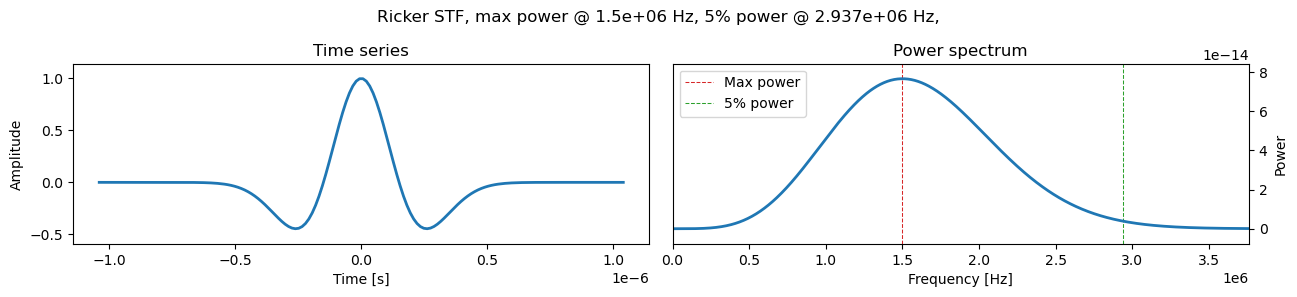

[2025-07-16 22:48:08,594] INFO: Deleting existing `sc_mesh_homogeneous_scatters` entity of type `simulation_configuration` ...
[2025-07-16 22:48:08,613] INFO: Deleting existing `sc_mesh_homogeneous` entity of type `simulation_configuration` ...


In [3]:
stf = sn.simple_config.stf.Ricker(center_frequency=CENTRAL_FREQUENCY)

stf.plot()

end_time = 5e-5

sim_config = sn.UnstructuredMeshSimulationConfiguration(
    unstructured_mesh=mesh_homogeneous_scatterers,
    name="sc_mesh_homogeneous_scatters",
    # Event specific configuration.
    event_configuration=sn.EventConfiguration(
        # Source wavelet.
        wavelet=stf,
        waveform_simulation_configuration=sn.WaveformSimulationConfiguration(
            end_time_in_seconds=end_time
        ),
    ),
)

# add simulation configuration to Project
p.add_to_project(
    sim_config, overwrite=True
    )


sim_config = sn.UnstructuredMeshSimulationConfiguration(
    unstructured_mesh=mesh_homogeneous,
    name="sc_mesh_homogeneous",
    # Event specific configuration.
    event_configuration=sn.EventConfiguration(
        # Source wavelet.
        wavelet=stf,
        waveform_simulation_configuration=sn.WaveformSimulationConfiguration(
            end_time_in_seconds=end_time
        ),
    ),
)

# add simulation configuration to Project
p.add_to_project(
    sim_config, overwrite=True
    )



In [4]:
@dataclasses.dataclass
class ArrayTransducer2D:
    nx: int
    dx: float
    x0: float
    
    array_name: str = "array_0"
    
    recording_fields: list[str] = dataclasses.field(
        default_factory=lambda: ["phi"]
    )
    
    side_set: str = "y1"
    
    def test_within_domain(self, domain: sn.domain.Domain) -> bool:
        x_bounds = domain.bounds.hc["x"]
        array_x_bounds = (self.x0, self.x0 + (self.nx - 1) * self.dx)
        return (x_bounds[0] <= array_x_bounds[0] and array_x_bounds[1] <= x_bounds[1])
    
    
    def create_salvus_source_receivers(self, source_index: int, f_source: int = 1):
            if source_index < 0 or source_index >= self.nx:
                raise ValueError("Source index out of range.")
            
            array_coordinates = np.zeros((self.nx))
            for i in range(self.nx):
                array_coordinates[i] = self.x0 + i * self.dx
                
            # source position
            source_x = array_coordinates[source_index]
            
            source = sn.simple_config.source.cartesian.SideSetScalarPoint2D(
            # Note that this 0 for Y is used for starting the projection
            # on the side set, it is not the coordinate of the source.
            point=(source_x, 0),
            f=f_source,
            direction="y",
            side_set_name=self.side_set,
            )            
            
            
            receivers = [
            sn.simple_config.receiver.cartesian.SideSetPoint2D(
                direction="y",
                point=(
                    array_coordinates[i],
                    0,
                ),
                # Note that we're using leading zeros, but if nx/ny is
                # really high this needs to be scaled up.
                station_code=f"{self.array_name}_x{i:03d}",
                fields=self.recording_fields,
                side_set_name=self.side_set,
            )
            for i in range(self.nx)
            ]
            
            return source, receivers
        
        



In [5]:
nx = 100

array_1 = ArrayTransducer2D(nx=nx, x0=0.005, dx=0.02 / nx, array_name="array_0")

print(array_1.test_within_domain(domain))

source_id = 14

source, receivers = array_1.create_salvus_source_receivers(
    source_index=source_id
)

event = sn.Event(
    event_name=f"array_a_source_{source_id}",
    sources=source,
    receivers=receivers,
)

add_events_to_Project(p, [event])
print(p.simulations.list())



source_id_arr = np.arange(0, 100, 14)

# These are all the events we'll use for imaging from now on out:
event_names_imaging = [
    f"array_a_source_{source_id}" for source_id in source_id_arr
]
# Now we define the actual inverse problem
events = []

for source_id in source_id_arr:
    source, receivers = array_1.create_salvus_source_receivers(
        source_index=source_id
    )
    events.append(sn.Event(
        event_name=f"array_a_source_{source_id}",
        sources=source,
        receivers=receivers,
    ))

    
add_events_to_Project(p, events)

p.viz.nb.simulation_setup(
    simulation_configuration="sc_mesh_homogeneous_scatters",
    events=events,
)

True
['sc_mesh_homogeneous', 'sc_mesh_homogeneous_scatters']


Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

In [6]:
p.simulations.launch(
    simulation_configuration="sc_mesh_homogeneous_scatters",
    events=p.events.list(),
    site_name=SITE_NAME,
    ranks_per_job=RANKS,
)

[2025-07-16 22:48:16,616] INFO: Simulations of 8 event(s) are still running. They will not be submitted again.


0

In [7]:
# The misfit configuration defines how synthetics are compared to observed data.
p += sn.MisfitConfiguration(
    name="L2_misfit_for_homo_model",
    # Could be observed data. Here we compare to the synthetic target.
    observed_data="sc_mesh_homogeneous_scatters",
    # Salvus comes with a variety of misfit functions. You can
    # also define your own.
    misfit_function="L2",
    # This is an acoustic simulation so we'll use recordings of phi.
    receiver_field="phi",
)


[2025-07-16 22:48:18,284] INFO: The same misfit_configuration with name `L2_misfit_for_homo_model` exists already in the project. Nothing will be done.


In [8]:

def add_inversion(Project, inv_config):
    if inv_config in Project.inversions.list():
        Project.inversions.delete(inv_config.name)
        Project+= inv_config
    else:
        Project+= inv_config
    return None


invconfig = sn.InverseProblemConfiguration(
    name="inversion_L2",
    # Starting model is the model without scatterers.
    prior_model="sc_mesh_homogeneous",
    # The events to use.
    events=event_names_imaging,
    misfit_configuration="L2_misfit_for_homo_model",
    # What parameters to invert for.
    mapping=sn.Mapping(
        scaling="relative_deviation_from_prior",
        inversion_parameters=["VP"],
        # region_of_interest=mesh_roi,
        # postprocess_model_update = tensor_to_orientation
    ),
    # The inversion method and its settings.
    method=sn.TrustRegion(initial_trust_region_linf=1.0),
    # The misfit configuration we defined above.
    
    # Compress the forward wavefield by subsampling in time.
    wavefield_compression=sn.WavefieldCompression(
        forward_wavefield_sampling_interval=10
    ),
    # Job submission settings.
    job_submission=sn.SiteConfig(site_name=SITE_NAME, ranks_per_job=RANKS),
)

add_inversion(p, invconfig)


# invconfig_one_event = sn.InverseProblemConfiguration(
#     name="inversion_L2_ONE_EVENT",
#     # Starting model is the model without scatterers.
#     prior_model="sc_mesh_heterogeneous_no_anomaly",
#     # The events to use.
#     events=["array_a_source_14"],
#     misfit_configuration="L2_misfit_for_heterogeneous_model",
#     # What parameters to invert for.
#     mapping=sn.Mapping(
#         scaling="relative_deviation_from_prior",
#         inversion_parameters=["RHO"],
#         region_of_interest=mesh_roi,
#         # postprocess_model_update = tensor_to_orientation
#     ),
#     # The inversion method and its settings.
#     method=sn.TrustRegion(initial_trust_region_linf=1.0),
#     # The misfit configuration we defined above.
    
#     # Compress the forward wavefield by subsampling in time.
#     wavefield_compression=sn.WavefieldCompression(
#         forward_wavefield_sampling_interval=10
#     ),
#     # Job submission settings.
#     job_submission=sn.SiteConfig(site_name=SITE_NAME, ranks_per_job=RANKS),
# )

# add_inversion(p, invconfig_one_event)




[2025-07-16 22:48:20,063] INFO: The project already contains an inverse problem configuration with name `inversion_L2` and the same input arguments. Nothing will be done.


In [9]:
p.inversions.set_job_submission_configuration(
    "inversion_L2", sn.SiteConfig(site_name=SITE_NAME, ranks_per_job=RANKS)
)

# Lastly we perform two iterations, and have a look at the results.
for i in range(20):
    p.inversions.iterate(
        inverse_problem_configuration="inversion_L2",
        timeout_in_seconds=360,
        ping_interval_in_seconds=10,
        delete_disposable_files="all",
    )
    


[2025-07-16 22:48:21,888] INFO: Resuming iteration #0.

[2025-07-16 22:48:21,890] INFO: 1 new tasks have been issued.
[2025-07-16 22:48:21,890] INFO: Processing task `misfit_and_gradient`


RuntimeError: Querying process 70081 failed with exit code 1.
stderr: 

stdout: 
your 131072x1 screen size is bogus. expect trouble

In [ ]:
interface_depth = 0.005

heterogeneous_model = lm.LayeredModel(
    [
        lm.material.acoustic.Velocity.from_params(rho=1450.0, vp=1500.0),
        lm.interface.Hyperplane.at(lm.interface.Depth(interface_depth)),
        sn.material.acoustic.Velocity.from_params(rho=2600.0, vp=5000.0),
    ]
)

# Add absorbing boundaries to layered model
heterogeneous_model_ab = sn.layered_meshing.MeshingProtocol(
    heterogeneous_model,
    ab=salvus.mesh.simple_mesh.basic_mesh.AbsorbingBoundaryParameters(
        free_surface=["y1"],
        number_of_wavelengths=1.5,
        reference_velocity=5000,
        reference_frequency=CENTRAL_FREQUENCY * 2,
    ),
)

mesh_heterogeneous = lm.mesh_from_domain(
    domain=domain,
    model=heterogeneous_model_ab,
    mesh_resolution=sn.MeshResolution(
        reference_frequency=CENTRAL_FREQUENCY * 2, elements_per_wavelength=2
    ),
)

mesh_heterogeneous_scatterers = mesh_heterogeneous.copy()

for scatterer_center in [np.array([x, 0.01]) for x in [0.05]]:
    distance_from_scatterer = np.linalg.norm(
        mesh_heterogeneous_scatterers.get_element_centroid()
        - scatterer_center,
        axis=1,
    )
    radius = 0.005
    anomaly = distance_from_scatterer < radius
    mesh_heterogeneous_scatterers.elemental_fields["RHO"] -= (
        anomaly[:, None] * 2400
    )
    mesh_heterogeneous_scatterers.elemental_fields["VP"] -= (
        anomaly[:, None] * 500
    )



In [ ]:
roi = (
    mesh_heterogeneous_scatterers.get_element_centroid()[:, 1]
    < y1 - interface_depth * 2
)

mesh_roi = mesh_heterogeneous_scatterers.copy()
fields = [field for field in mesh_roi.elemental_fields]

# remove all attached fileds in mesh
for field in fields:
    mesh_roi.elemental_fields.pop(field)

# attach roi (Boolean mask)
mesh_roi.attach_field(
    "region_of_interest",
    np.broadcast_to(roi[:, None], mesh_roi.connectivity.shape),
)

In [ ]:
sc = sn.UnstructuredMeshSimulationConfiguration(
    unstructured_mesh=mesh_heterogeneous,
    name="sc_mesh_heterogeneous_no_anomaly",
    event_configuration=sn.EventConfiguration(
        wavelet=stf,
        waveform_simulation_configuration=sn.WaveformSimulationConfiguration(
            end_time_in_seconds=end_time
        ),
    ),
)


# add simulation configuration to Project
p.add_to_project(
    sc, overwrite=True
    )



sc = sn.UnstructuredMeshSimulationConfiguration(
    unstructured_mesh=mesh_heterogeneous_scatterers,
    name="sc_mesh_heterogeneous",
    event_configuration=sn.EventConfiguration(
        wavelet=stf,
        waveform_simulation_configuration=sn.WaveformSimulationConfiguration(
            end_time_in_seconds=end_time
        ),
    ),
)

# add simulation configuration to Project
p.add_to_project(
    sc, overwrite=True
    )





In [ ]:
p.viz.nb.simulation_setup(
    simulation_configuration="sc_mesh_heterogeneous",
    events=f"array_a_source_14",
)

    

In [ ]:
# The misfit configuration defines how synthetics are compared to observed data.
p += sn.MisfitConfiguration(
    name="L2_misfit_for_heterogeneous_model",
    # Could be observed data. Here we compare to the synthetic target.
    observed_data="sc_mesh_heterogeneous",
    # Salvus comes with a variety of misfit functions. You can
    # also define your own.
    misfit_function="L2",
    # This is an acoustic simulation so we'll use recordings of phi.
    receiver_field="phi",
)


In [ ]:
source_id_arr = np.arange(0, 100, 14)

# These are all the events we'll use for imaging from now on out:
event_names_imaging = [
    f"array_a_source_{source_id}" for source_id in source_id_arr
]
# Now we define the actual inverse problem
events = []

for source_id in source_id_arr:
    source, receivers = array_1.create_salvus_source_receivers(
        source_index=source_id
    )
    events.append(sn.Event(
        event_name=f"array_a_source_{source_id}",
        sources=source,
        receivers=receivers,
    ))

    
add_events_to_Project(p, events)

invconfig = sn.InverseProblemConfiguration(
    name="inversion_L2",
    # Starting model is the model without scatterers.
    prior_model="sc_mesh_heterogeneous_no_anomaly",
    # The events to use.
    events=event_names_imaging,
    misfit_configuration="L2_misfit_for_heterogeneous_model",
    # What parameters to invert for.
    mapping=sn.Mapping(
        scaling="relative_deviation_from_prior",
        inversion_parameters=["RHO"],
        region_of_interest=mesh_roi,
        # postprocess_model_update = tensor_to_orientation
    ),
    # The inversion method and its settings.
    method=sn.TrustRegion(initial_trust_region_linf=1.0),
    # The misfit configuration we defined above.
    
    # Compress the forward wavefield by subsampling in time.
    wavefield_compression=sn.WavefieldCompression(
        forward_wavefield_sampling_interval=10
    ),
    # Job submission settings.
    job_submission=sn.SiteConfig(site_name=SITE_NAME, ranks_per_job=RANKS),
)



invconfig_one_event = sn.InverseProblemConfiguration(
    name="inversion_L2_ONE_EVENT",
    # Starting model is the model without scatterers.
    prior_model="sc_mesh_heterogeneous_no_anomaly",
    # The events to use.
    events=["array_a_source_14"],
    misfit_configuration="L2_misfit_for_heterogeneous_model",
    # What parameters to invert for.
    mapping=sn.Mapping(
        scaling="relative_deviation_from_prior",
        inversion_parameters=["RHO"],
        region_of_interest=mesh_roi,
        # postprocess_model_update = tensor_to_orientation
    ),
    # The inversion method and its settings.
    method=sn.TrustRegion(initial_trust_region_linf=1.0),
    # The misfit configuration we defined above.
    
    # Compress the forward wavefield by subsampling in time.
    wavefield_compression=sn.WavefieldCompression(
        forward_wavefield_sampling_interval=10
    ),
    # Job submission settings.
    job_submission=sn.SiteConfig(site_name=SITE_NAME, ranks_per_job=RANKS),
)



def add_inversion(Project, inv_config):
    if inv_config in Project.inversions.list():
        Project.inversions.delete(inv_config.name)
        Project+= inv_config
    else:
        Project+= inv_config
    return None

add_inversion(p, invconfig)
add_inversion(p, invconfig_one_event)


In [ ]:
p+= invconfig_one_event

In [ ]:
p.inversions.set_job_submission_configuration(
    "inversion_L2", sn.SiteConfig(site_name=SITE_NAME, ranks_per_job=RANKS)
)

In [ ]:
p.simulations.query(block=True)

In [ ]:
# Lastly we perform two iterations, and have a look at the results.
for i in range(20):
    p.inversions.iterate(
        inverse_problem_configuration="inversion_L2_ONE_EVENT",
        timeout_in_seconds=360,
        ping_interval_in_seconds=10,
        delete_disposable_files="all",
    )

In [ ]:
p.viz.nb.inversion(inverse_problem_configuration="inversion_L2_ONE_EVENT")